In [13]:
#%matplotlib widget
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import QTable, Column, vstack
import numpy as np
import pandas as pd

from importlib import reload

from linetools.lists.linelist import LineList
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.spectra.lsf import LSF

import interface
import builder
import modeler

import jax
import numpyro as npr

In [2]:
interface.get_lines_for_species('FeII', 'linetools', 'ISM')[-8:]

read_sets: Using set file -- 
  /Users/kt/Dropbox/code_projects/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


A,el,nj,nk,group,line_name,Ek,f,wrest,Ref,mol,Ej,Am,ion,Ex,Jj,Jk,Z,gk,gj,gamma,Id,species
1 / s,,,,,,1 / cm,,Angstrom,,,1 / cm,,,1 / cm,,,,,,1 / s,,
float64,int64,int64,int64,int64,str12,float64,float64,float64,str14,str2,float64,int64,int64,float64,float64,float64,int64,int64,int64,float64,int64,str6
161000.0,0,0,0,1,FeII 1901,52582.51,7.0000e-05,1901.7730,Morton2003,--,0.0,0,2,0.0,0.0,0.0,26,8,10,0.0,388,FeII
3000000.0,0,0,0,1,FeII 2249,44446.878,1.8200e-03,2249.8768,Morton2003,--,0.0,0,2,0.0,0.0,0.0,26,8,10,331000000.0,402,FeII
3180000.0,0,0,0,1,FeII 2260,44232.512,2.4400e-03,2260.7805,Morton2003,--,0.0,0,2,0.0,0.0,0.0,26,0,10,258000000.0,403,FeII
173000000.0,0,0,0,1,FeII 2344,42658.224,1.1400e-01,2344.2139,Morton2003,--,0.0,0,2,0.0,0.0,0.0,26,8,10,268000000.0,406,FeII
37000000.0,0,0,0,1,FeII 2374,42114.818,3.1300e-02,2374.4612,Morton2003,--,0.0,0,2,0.0,0.0,0.0,26,0,10,309000000.0,407,FeII
313000000.0,0,0,0,1,FeII 2382,41968.046,3.2000e-01,2382.7652,Morton2003,--,0.0,0,2,0.0,0.0,0.0,26,2,10,313000000.0,408,FeII
86100000.0,0,0,0,1,FeII 2586,38660.043,6.9100e-02,2586.6500,Morton2003,--,0.0,0,2,0.0,0.0,0.0,26,8,10,272000000.0,419,FeII
236000000.0,0,0,0,1,FeII 2600,38458.981,2.3900e-01,2600.1729,Morton2003,--,0.0,0,2,0.0,0.0,0.0,26,0,10,270000000.0,422,FeII


In [3]:
zvals = [
    0.00002,
    0.00007,
    0.0002,
    #0.00062,
    #0.00076,
    #0.00086,
    #0.001,
    #0.00107,
    #0.0012,
]
vcens = np.array(zvals) * interface.aco.c.to('km/s')
components = {}
for idx, vcen in enumerate(vcens):
    comp = {'species': 'FeII',
            'zcen': 0.0,
            'vmin': str(vcen-5*u.km/u.s),
            'vmax': str(vcen+5*u.km/u.s),
            'linelist': {'source': 'linetools', 'name':'ISM'}
           }
    components[f'FeII_{idx}'] = comp

In [4]:
if False:
    components = {
        'CrII_0': {
            'species': 'CrII',
            'zcen': 0.0,
            'vmin': '-100 km/s',
            'vmax': '100 km/s',
            'linelist': {
                'source': 'linetools',
                'name': 'ISM',
            }
        },
        'ZnII_0': {
            'species': 'ZnII',
            'zcen': 0.0,
            'vmin': '-100 km/s',
            'vmax': '100 km/s',
            'linelist': {
                'source': 'linetools',
                'name': 'ISM',
            }
        },
    }

spectrum_name = 'e230m_LMC-Sk-70-115'
spec_df = pd.read_csv(f"/Users/kt/Dropbox/METAL/code/carbon_monoxide_systematic/data/cont_fit/mcabund_{spectrum_name}.csv")
spectrum = QTable(data={
    "wavelength": spec_df.wave.values * u.Angstrom,
    "flux": u.quantity.Quantity(spec_df.flux.values),
    "flux_sd": u.quantity.Quantity(spec_df.err.values),
    "continuum": u.quantity.Quantity(spec_df.best_fit_spec.values),
})
lsf_obj = LSF(instr_config={'name': 'STIS', 'grating':'E230M', 'slit': '0.2x0.2'})


In [5]:
comp_lines = interface.parse_components(components)
clgs, spec_chunks = interface.match_component_lines_and_spectrum(comp_lines, spectrum[spectrum['wavelength']>(1850*u.Angstrom)], 100*u.km/u.s)
for idx in range(len(spec_chunks)):
    spec_chunks[idx]['continuum_orig'] = spec_chunks[idx]['continuum']

In [6]:
deltas = [0, 0.025, 0.025, -0.025]

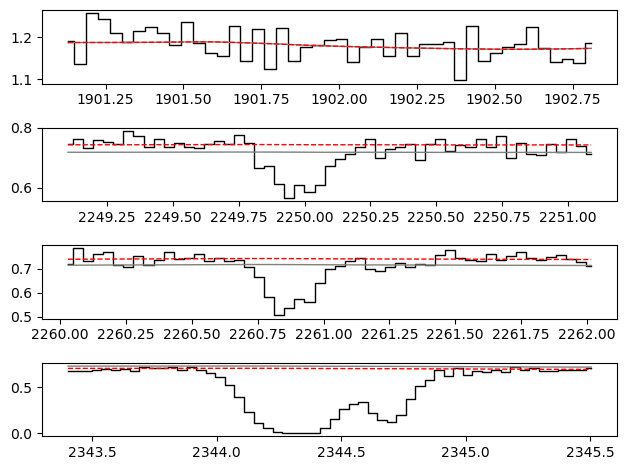

In [7]:
plt.close('all')
fig, axes = plt.subplots(nrows=len(spec_chunks))

for idx, spec_chunk in enumerate(spec_chunks):
    ax = axes[idx]
    ax.plot(spec_chunk['wavelength'], spec_chunk['flux'], color='black', lw=1, ds='steps-mid')
    ax.plot(spec_chunk['wavelength'], spec_chunk['continuum_orig'], color='gray', lw=1)
    spec_chunk['continuum'] = spec_chunk['continuum_orig'] + deltas[idx]
    ax.plot(spec_chunk['wavelength'], spec_chunk['continuum'], color='red', lw=1, ls='--')
    
plt.tight_layout();

In [8]:
def spectrum_model(comp_names, likelihoods):
    comp_names = np.array(comp_names)
    log10_N_dict = {comp_name: npr.sample(f'{comp_name}_log10_N', npr.distributions.Uniform(10, 16))
                    for comp_name in comp_names}
    vcen_km_s_dict = {comp_name: npr.sample(f'{comp_name}_vcen_km_s', npr.distributions.Uniform(-100, 100))
                     for comp_name in comp_names}
    b_km_s_dict = {comp_name: npr.sample(f'{comp_name}_b_km_s', npr.distributions.Uniform(1, 50))
                   for comp_name in comp_names}

    [likelihood(log10_N_dict, vcen_km_s_dict, b_km_s_dict) for likelihood in likelihoods]

In [10]:
flux_model_synthesizers = []
likelihoods = []

for idx, (clg, spec_chunk) in enumerate(zip(clgs, spec_chunks)):
    dense_wave, n_subdivide = interface.upsample_wavelength(spec_chunk['wavelength'], velocity_step=1*u.km/u.s)
    synthesizer = builder.get_normed_flux_synthesizer(clg, dense_wave)
    convolver = builder.get_convolved_spectrum_func(lambda x: lsf_obj.get_lsf(x), dense_wave, n_subdivide)

    flux_model_synthesizer = modeler.get_flux_model_synthesizer(
        synthesizer,
        convolver,
        spec_chunk['continuum'],
        clg['compname'])
    
    likelihood_gaussian = modeler.get_likelihood_gaussian(
        flux_model_synthesizer,
        spec_chunk['flux'],
        spec_chunk['flux_sd'],
        spectrum_name,
        idx)

    flux_model_synthesizers.append(flux_model_synthesizer)
    likelihoods.append(likelihood_gaussian)

all_active_compnames = np.unique(np.concatenate([clg['compname'] for clg in clgs]))

In [134]:
optimizer = npr.optim.Adam(1e-3)
guide = npr.infer.autoguide.AutoDelta(spectrum_model)
svi = npr.infer.SVI(spectrum_model, guide, optimizer, loss=npr.infer.Trace_ELBO(), )
init_state = svi.init(jax.random.PRNGKey(0), all_active_compnames, likelihoods)
state = svi.run(jax.random.PRNGKey(0), 12000, all_active_compnames, likelihoods, init_state=init_state, stable_update=True)

100%|█| 12000/12000 [00:08<00:00, 1487.53it/s, init loss: 32155.5478, avg. loss 


In [135]:
#params = svi.get_params(state)  # get guide's parameters
quantiles = guide.sample_posterior(jax.random.PRNGKey(0), state.params, all_active_compnames, likelihoods)  # get means of posterior samples

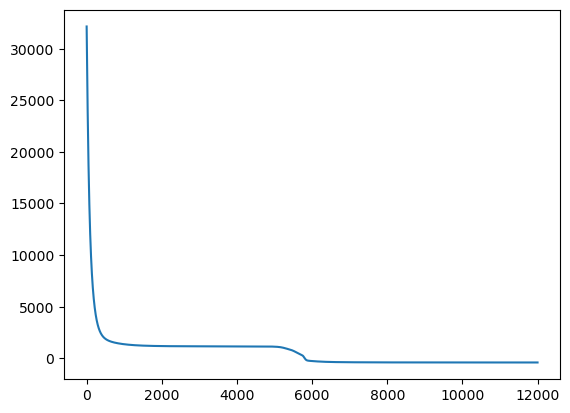

In [136]:
plt.close('all')
plt.plot(state.losses)

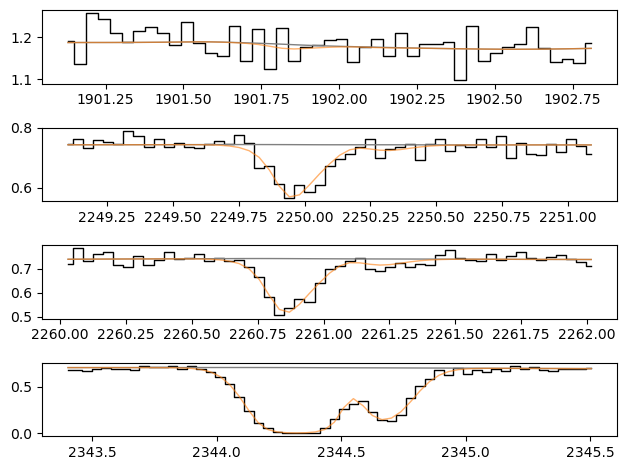

In [137]:
plt.close('all')
fig, axes = plt.subplots(nrows=len(spec_chunks))

for idx, spec_chunk in enumerate(spec_chunks):
    flux_models = quantiles[f'{spectrum_name}_{idx}_flux_model']
    ax = axes[idx]
    ax.plot(spec_chunk['wavelength'], spec_chunk['flux'], color='black', lw=1, ds='steps-mid')
    ax.plot(spec_chunk['wavelength'], spec_chunk['continuum'], color='gray', lw=1)
    ax.plot(spec_chunk['wavelength'], flux_models, color='C1', lw=1, alpha=0.6);

plt.tight_layout();

In [ ]:
f'{comp_name}_log10_N'
f'{comp_name}_vcen_km_s'
f'{comp_name}_b_km_s'

In [15]:
active_clgs = vstack(clgs)


In [22]:
grpd = active_clgs.group_by(['compname'])

In [57]:
init_params = {}
b_default = 10.0
tau_target = 0.5

for group in grpd.groups:
    comp_name = group['compname'][0]
    comp_def = components[comp_name]
    
    vstart = 0.5*(u.Quantity(comp_def['vmin']) + u.Quantity(comp_def['vmax'])).to('km/s').value

    flam = (group['f'] * group['wrest']).to('cm').value
    ref_flam = flam.max()
    norm = (builder.opacity_conversion_constant * ref_flam /
            (np.sqrt(np.pi)*(b_default*u.km/u.s).to('cm/s').value)
           )
    
    init_params[f'{comp_name}_vcen_km_s'] = vstart
    init_params[f'{comp_name}_b_km_s'] = b_default
    init_params[f'{comp_name}_log10_N'] = np.log10(tau_target / norm)

In [59]:
prngkey_mcmc = jax.random.PRNGKey(0)

step = npr.infer.NUTS(spectrum_model)
mcmc = npr.infer.MCMC(step, num_warmup=400, num_samples=1000, num_chains=2,
                       progress_bar=True)
mcmc.run(prngkey_mcmc, all_active_compnames, likelihoods)

/var/folders/n1/cqlb_pj11_17vqytt0tyvd_h0000gn/T/ipykernel_47917/2759606038.py:4: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = npr.infer.MCMC(step, num_warmup=400, num_samples=1000, num_chains=2,
warmup:  16%|▏| 228/1400 [02:40<13:45,  1.42it/s, 1023 steps of size 9.12e-03. a


KeyboardInterrupt: 

In [10]:
import arviz

In [11]:
trace = arviz.from_numpyro(mcmc)

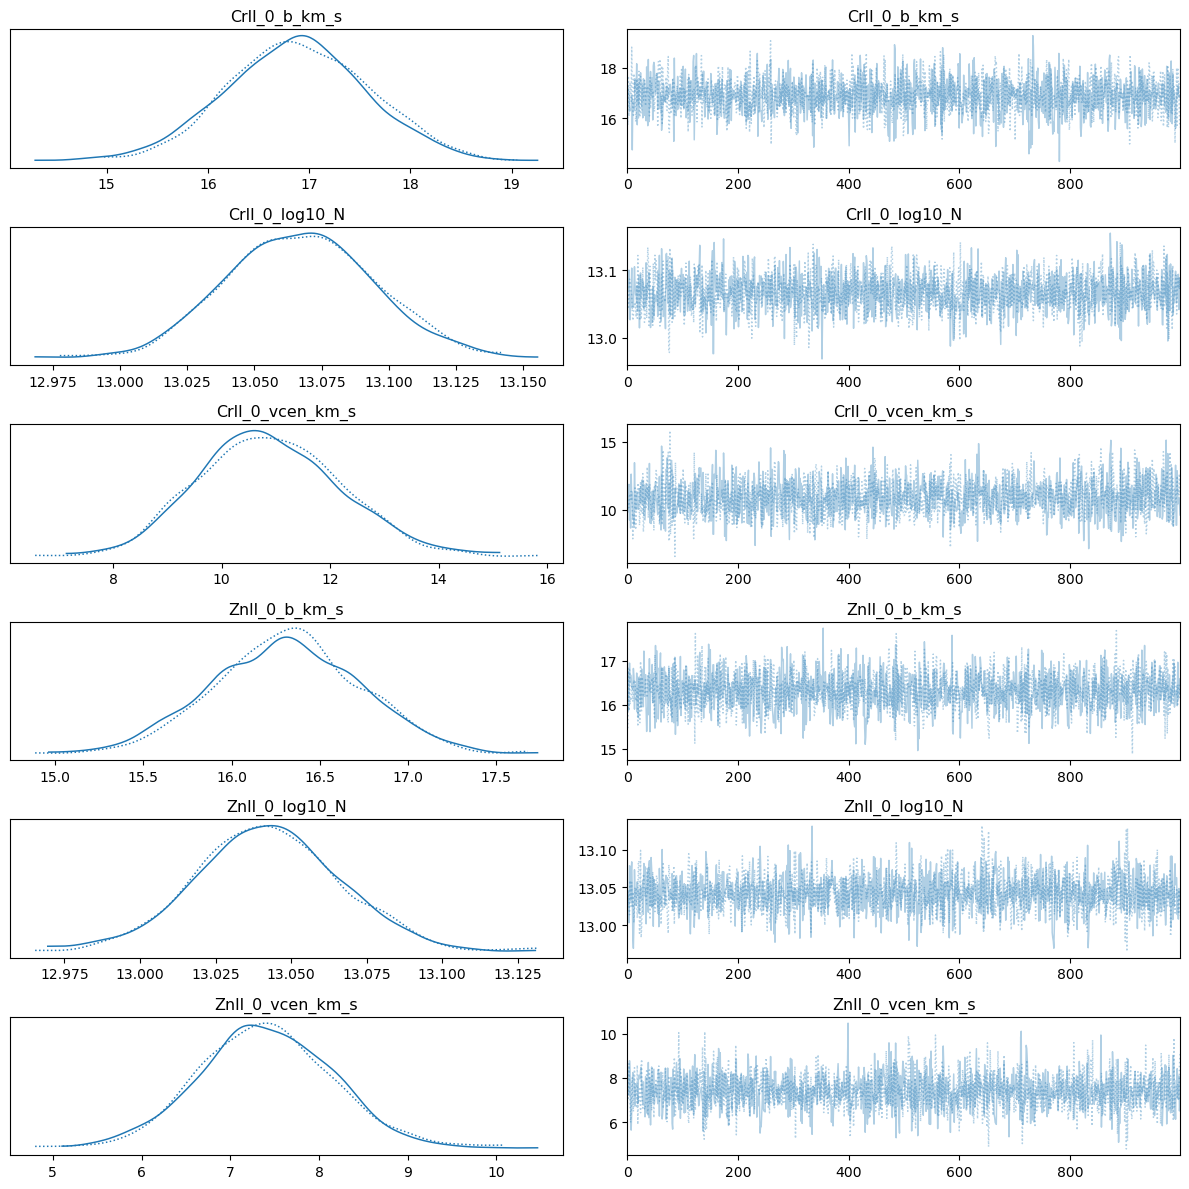

In [12]:
arviz.plot_trace(trace, var_names='~flux_model', filter_vars='like')
plt.tight_layout();

In [13]:
samples = mcmc.get_samples()

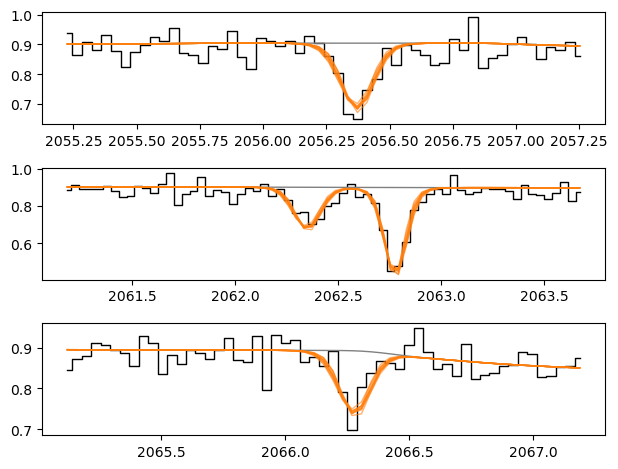

In [15]:
plt.close('all')
fig, axes = plt.subplots(nrows=len(spec_chunks))

for idx, spec_chunk in enumerate(spec_chunks):
    flux_models = samples[f'sk-67d211_stis_e230m_{idx}_flux_model']
    ax = axes[idx]
    ax.plot(spec_chunk['wavelength'], spec_chunk['flux'], color='black', lw=1, ds='steps-mid')
    ax.plot(spec_chunk['wavelength'], spec_chunk['continuum'], color='gray', lw=1)
    ax.plot(spec_chunk['wavelength'], flux_models[::200].T, color='C1', lw=1, alpha=0.6);

plt.tight_layout();

# tests to make pytesty later

In [ ]:
comps_with_line_lookup = {
    'comp_name': {
        "species": "ZnII",
        'zcen': 0,
        'vmin': '-100 km/s',
        'vmax': '100 km/s',
        'linelist': {
            'source': 'linetools',
            'name': 'ISM',
        }
    }
}

interface.parse_components(comps_with_line_lookup)

In [ ]:
comps_with_lines_defined = {
    'comp_name': {
        "species": "ZnII",
        'zcen': 0,
        'vmin': '-100 km/s',
        'vmax': '100 km/s',
        'lines': {
            'wrest': ['2026.137 Angstrom', '2062.664 Angstrom'],
            'f': [0.501, 0.253],
            'gamma': ['407000000 1/second', '0 1/second'],
            'line_name': ['ZnII 2026', 'ZnII 2062']
        }
        
    }
}
interface.parse_components(comps_with_lines_defined)